In [1]:
# default_exp camera_projection

# arg_tools

> A toolset for .

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#|export

import numpy as np
import scipy as sp
import cv2
from cv2 import aruco
import apriltag
import time
import yaml

import pytransform3d.rotations as pr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import sys
import gdown
from zipfile import ZipFile

from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv

In [4]:
#hide

def gdown_unzip(id, filename):
    dataset_url = 'https://drive.google.com/u/1/uc?id=' + id
    dataset_name = filename
        
    if not os.path.isdir(dataset_name):
        gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
        zip_file = ZipFile(dataset_name + '.zip')
        zip_file.extractall()
        #zip_file.extractall(dataset_name) # depends on how to zip it
        zip_file.close()

In [5]:
#hide

id = '1DN5tiV_WII_aJM3DLijPnq5OLtI0HAq1'
filename = "ViperX_apriltags"
gdown_unzip(id, filename)

In [6]:
#|export

class camera_projection:
    def __init__(self):
        self.camera_info_path = 'ViperX_apriltags/camera_info.yaml'
        self.img_path = 'ViperX_apriltags/rgb/'
        self.depth_path = 'ViperX_apriltags/depth/'
        self.tag_size = 0.0415
        self.s = 0.5 * self.tag_size
        
    def read_camera_info(self):
        with open(self.camera_info_path, "r") as stream:
            try:
                camera_data = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        self.camera_matrix = np.array(camera_data['camera_matrix']['data'])
        self.camera_matrix = self.camera_matrix.reshape(3, 3)
        self.dist_coeffs = np.array(camera_data['distortion_coefficients']['data'])
        self.dist_coeffs = self.dist_coeffs.reshape(1, 5)
        self.cameraParams_Intrinsic = [self.camera_matrix[0,0], self.camera_matrix[1,1], 
                                       self.camera_matrix[0,2], self.camera_matrix[1,2]]
        # cameraParams_Intrinsic = [camera_fx, camera_fy, 
        #                           camera_cx, camera_cy]
        
    def read_images(self, idx):
        self.img_path = self.img_path + str(idx) + '.png'
        self.depth_path = self.depth_path + str(idx) + '.png'
        self.img = cv2.imread(self.img_path)
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        self.depth = cv2.imread(self.depth_path, -cv2.IMREAD_ANYDEPTH)
        self.img_dst = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        
    def apriltag_detection(self):
        print("[INFO] detecting AprilTags...")
        options = apriltag.DetectorOptions(families="tag36h11")
        detector = apriltag.Detector(options)
        #results = detector.detect(gray)
        self.detection_results, dimg = detector.detect(self.gray, return_image=True)
        print("[INFO] {} total AprilTags detected".format(len(self.detection_results)))
        
    def solvePnP(self):
        img_pts = self.detection_results[0].corners.reshape(1,4,2)
        obj_pt1 = [-self.s, -self.s, 0.0]
        obj_pt2 = [ self.s, -self.s, 0.0]
        obj_pt3 = [ self.s,  self.s, 0.0]
        obj_pt4 = [-self.s,  self.s, 0.0]
        obj_pts = obj_pt1 + obj_pt2 + obj_pt3 + obj_pt4
        obj_pts = np.array(obj_pts).reshape(4,3)
        # print(img_pts)
        # print(obj_pts)
        _, self.r_vec, self.t_vec = cv2.solvePnP(obj_pts, img_pts, self.camera_matrix, 
                                       self.dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
        R_mat, _ = cv2.Rodrigues(self.r_vec)
        T = np.hstack((R_mat, self.t_vec)).reshape(3,4)
        tag_pose = np.vstack((T, [0,0,0,1])).reshape(4,4)
        dist = np.linalg.norm(self.t_vec)
    def draw_point(self, tag_2_inv, base2joint):
        # --------------- project a point ---------------
        tag2joint = np.matmul(tag_2_inv, base2joint)
        obj_pts = np.array([tag2joint[0,3], tag2joint[1,3], tag2joint[2,3]]).reshape(1,3)
        proj_img_pts, jac = cv2.projectPoints(obj_pts, self.r_vec, self.t_vec, 
                                              self.camera_matrix, self.dist_coeffs)
        proj_img_pts = np.array(proj_img_pts).reshape(2,1)
        # --------------- draw a point ---------------
        draw_image = cv2.circle(self.img_dst, (int(proj_img_pts[0]), int(proj_img_pts[1])), 
                                radius=5, color=(255, 0, 0), thickness=-1)
        return draw_image

In [7]:
cam_project = camera_projection()

In [8]:
cam_project.read_camera_info()
cam_project.read_images(300)
cam_project.apriltag_detection()
cam_project.solvePnP()

[INFO] detecting AprilTags...
[INFO] 1 total AprilTags detected


In [9]:
r = R.from_euler('x', 180, degrees=True)
r_tran = np.identity(4)
r_tran[:3,:3] = r.as_matrix()

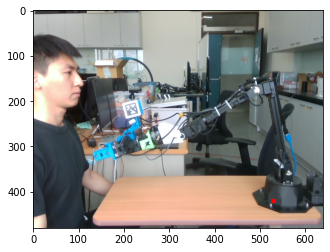

In [10]:
with open('ViperX_apriltags/pose/' + str(300) + '.yaml', "r") as stream:
    try:
      data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
      print(exc)

tag_2 = np.array(data['Tag_2_pose'][0]['transformation_matrix'][0])
tag_2 = tag_2.reshape(4, 4)
tag_2_inv = np.matmul(tag_2, r_tran)
tag_2_inv = inv(tag_2_inv)

draw_image = cam_project.draw_point(tag_2_inv, np.identity(4))

figsize = 15 # param larger is bigger, adjust as needed
plt.rcParams['figure.figsize'] = (figsize, figsize)
plt.imshow(draw_image, cmap = 'brg')
plt.show()

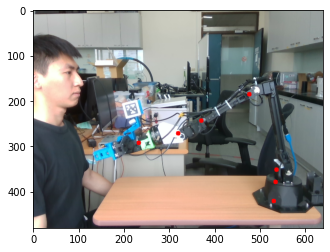

In [11]:
joints = ['Joint_1_pose', 'Joint_2_pose', 
          'Joint_3_pose', 'Joint_4_pose', 
          'Joint_5_pose', 'Joint_6_pose']

for joint in joints:
    joint_data = np.array(data[joint][0]['transformation_matrix'][0])
    joint_data = joint_data.reshape(4, 4)
    if joints.index(joint) > 0:
      joint_data = np.matmul(previous_data, joint_data)
    draw_image = cam_project.draw_point(tag_2_inv, joint_data)
    previous_data = joint_data
    
plt.imshow(draw_image, cmap = 'brg')
plt.show()

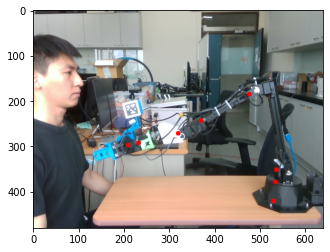

In [12]:
ee = np.array(data['EE_pose'][0]['transformation_matrix'][0])
ee = ee.reshape(4, 4)
draw_image = cam_project.draw_point(tag_2_inv, ee)

plt.imshow(draw_image, cmap = 'brg')
plt.show()